# Example : k fold cross-validation with an input file 

DeepBiome package takes microbiome abundance data as input and uses the phylogenetic taxonomy to guide the decision of the optimal number of layers and neurons in the deep learning architecture.

To use DeepBiome, you can experiment (1) __k times repetition__ or (2) __k fold cross-validation__.
For each experiment, we asuume that the dataset is given by
- __A list of k input files for k times repetition.__
- __One input file for k fold cross-validation.__

This notebook contains an example of (2) __k fold cross-validation__ for the deep neural netowrk using deepbiome.

## 1. Load library

First, we load the DeepBiome package. The DeepBiome package is built on the tensorflow and keras library

In [1]:
import os
import logging
import json
from pkg_resources import resource_filename

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepbiome import deepbiome

Using TensorFlow backend.


## 2. Prepare the dataset

In this example, we assume that we have __one input file for k times repetition.__

DeepBiome needs 3 data files as follows:
1. **the tree information**
1. **the input file**
1. **y**

For `k` fold cross-validation, we can use an input file.
In addition, we can set **the training index for each fold**. If we set the index file, DeepBiome build the training set for each fold based on each fold index in the index file. If not, DeepBiome will generate the index file locally.
        
Eath data should have the csv format as follow:

### Example of the tree information

First we need a file about the phylogenetic tree information. This tree information file should have the format below:

In [2]:
tree_information = pd.read_csv(resource_filename('deepbiome', 'tests/data/genus48_dic.csv'))
tree_information

,Genus,Family,Order,Class,Phylum,Domain
0,Streptococcus,Streptococcaceae,Lactobacillales,Bacilli,Firmicutes,Bacteria
1,Tropheryma,Cellulomonadaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
2,Veillonella,Veillonellaceae,Selenomonadales,Negativicutes,Firmicutes,Bacteria
3,Actinomyces,Actinomycetaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
4,Flavobacterium,Flavobacteriaceae,Flavobacteriales,Flavobacteria,Bacteroidetes,Bacteria
5,Prevotella,Prevotellaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
6,Porphyromonas,Porphyromonadaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
7,Parvimonas,Clostridiales_Incertae_Sedis_XI,Clostridiales,Clostridia,Firmicutes,Bacteria
8,Fusobacterium,Fusobacteriaceae,Fusobacteriales,Fusobacteria,Fusobacteria,Bacteria
9,Propionibacterium,Propionibacteriaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria


This file has `.csv` format below:

In [3]:
with open(resource_filename('deepbiome', 'tests/data/genus48_dic.csv')) as f:
    print(f.read())

Genus,Family,Order,Class,Phylum,Domain
Streptococcus,Streptococcaceae,Lactobacillales,Bacilli,Firmicutes,Bacteria
Tropheryma,Cellulomonadaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
Veillonella,Veillonellaceae,Selenomonadales,Negativicutes,Firmicutes,Bacteria
Actinomyces,Actinomycetaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
Flavobacterium,Flavobacteriaceae,Flavobacteriales,Flavobacteria,Bacteroidetes,Bacteria
Prevotella,Prevotellaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
Porphyromonas,Porphyromonadaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
Parvimonas,Clostridiales_Incertae_Sedis_XI,Clostridiales,Clostridia,Firmicutes,Bacteria
Fusobacterium,Fusobacteriaceae,Fusobacteriales,Fusobacteria,Fusobacteria,Bacteria
Propionibacterium,Propionibacteriaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
Gemella,Bacillales_Incertae_Sedis_XI,Bacillales,Bacilli,Firmicutes,Bacteria
Rothia,Micrococcaceae,Actinomycetales,Actinobacteria,Act

### Example of the input file

Below is an example of the input file.
This example has 1000 samples' microbiome abandunce.

In [4]:
x = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_x.csv'))
x.head()

,Streptococcus,Tropheryma,Veillonella,Actinomyces,Flavobacterium,Prevotella,Porphyromonas,Parvimonas,Fusobacterium,Propionibacterium,...,Microbacterium,Sphingomonas,Chryseobacterium,Bacteroides,Bdellovibrio,Streptophyta,Lachnospiracea_incertae_sedis,Paracoccus,Fastidiosipila,Pseudonocardia
0,841,0,813,505,5,3224,0,362,11,65,...,0,87,0,0,0,0,0,0,0,2133
1,1445,0,1,573,0,1278,82,85,69,154,...,0,1,2,0,0,0,0,0,0,3638
2,1259,0,805,650,0,1088,0,0,74,0,...,0,2,8,1,39,0,0,0,0,3445
3,982,0,327,594,0,960,81,19,9,0,...,157,1,0,4,60,0,0,0,0,3507
4,1162,0,130,969,163,1515,167,4,162,3,...,0,9,0,0,0,0,60,0,0,3945


In [5]:
x.tail()

,Streptococcus,Tropheryma,Veillonella,Actinomyces,Flavobacterium,Prevotella,Porphyromonas,Parvimonas,Fusobacterium,Propionibacterium,...,Microbacterium,Sphingomonas,Chryseobacterium,Bacteroides,Bdellovibrio,Streptophyta,Lachnospiracea_incertae_sedis,Paracoccus,Fastidiosipila,Pseudonocardia
995,1401,4,30,526,0,923,25,0,127,0,...,0,0,7,0,0,0,0,0,0,4470
996,2655,6,106,74,0,952,76,13,158,125,...,0,2,0,0,0,0,0,0,0,2826
997,335,0,71,259,67,718,1,4,4,167,...,0,246,0,0,6,0,0,0,0,6527
998,649,69,966,1227,0,508,2,30,550,0,...,0,0,0,0,0,6,0,0,0,4402
999,1258,0,0,1119,0,2348,25,0,137,176,...,0,2,0,0,0,0,0,0,0,2585


This file has `.csv` format below:

In [6]:
with open(resource_filename('deepbiome', 'tests/data/onefile_x.csv')) as f:
    print(f.read())

"Streptococcus","Tropheryma","Veillonella","Actinomyces","Flavobacterium","Prevotella","Porphyromonas","Parvimonas","Fusobacterium","Propionibacterium","Gemella","Rothia","Granulicatella","Neisseria","Lactobacillus","Megasphaera","Catonella","Atopobium","Campylobacter","Capnocytophaga","Solobacterium","Moryella","TM7_genera_incertae_sedis","Staphylococcus","Filifactor","Oribacterium","Burkholderia","Sneathia","Treponema","Moraxella","Haemophilus","Selenomonas","Corynebacterium","Rhizobium","Bradyrhizobium","Methylobacterium","OD1_genera_incertae_sedis","Finegoldia","Microbacterium","Sphingomonas","Chryseobacterium","Bacteroides","Bdellovibrio","Streptophyta","Lachnospiracea_incertae_sedis","Paracoccus","Fastidiosipila","Pseudonocardia"
841,0,813,505,5,3224,0,362,11,65,156,1,55,0,1,20,382,1,333,24,80,43,309,2,3,4,0,1,32,0,2,4,382,0,0,96,23,0,0,87,0,0,0,0,0,0,0,2133
1445,0,1,573,0,1278,82,85,69,154,436,3,0,61,440,0,394,83,33,123,0,49,414,0,0,37,0,0,42,0,0,384,27,0,0,0,146,0,0,1,2,0,0,0,0

### Example of the Y (regression)

This is an example of the output file for regression problem.

In [7]:
y = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_regression_y.csv'))
y.head()

,x1
0,4.997270
1,5.004092
2,5.485126
3,5.489590
4,1.500001


In [8]:
y.tail()

,x1
995,2.609926
996,5.488959
997,3.498418
998,5.486107
999,5.319623


For one repetition, the deepbiome will use the one column.

In [9]:
y.iloc[:,0].head()

0    4.997270
1    5.004092
2    5.485126
3    5.489590
4    1.500001
Name: x1, dtype: float64

In [10]:
y.iloc[:,0].tail()

995    2.609926
996    5.488959
997    3.498418
998    5.486107
999    5.319623
Name: x1, dtype: float64

### Example of the Y (classification)

This is an example of the output file for classification problem. Below example file has 1000 samples in rows, 1000 repetition in columns.

In [11]:
y = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_classification_y.csv'))
y.head()

,V1
0,1.0
1,1.0
2,0.0
3,0.0
4,1.0


In [12]:
y.tail()

,V1
995,1.0
996,0.0
997,1.0
998,0.0
999,1.0


For one repetition, DeepBiome will use the one column.

In [13]:
y.iloc[:,0].head()

0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: V1, dtype: float64

In [14]:
y.iloc[:,0].tail()

995    1.0
996    0.0
997    1.0
998    0.0
999    1.0
Name: V1, dtype: float64

### Exmple of the training index file for `k` fold cross-validation

For each fold, we have to set the training and test set. If the index file is given, DeepBiome sets the training set and test set based on the index file for 5 fold cross-validation. Below is the example of the index file. Each column has the training indices for each fold. DeepBiome will only use the samples in this index set for training.

In [15]:
idxs = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_idx.csv'), dtype=np.int)
idxs.head()

,0,1,2,3,4
0,0,0,2,0,0
1,1,1,3,1,1
2,2,2,4,2,3
3,5,3,6,3,4
4,6,4,8,4,5


In [16]:
idxs.tail()

,0,1,2,3,4
795,993,995,993,994,995
796,994,996,994,995,996
797,996,997,995,996,997
798,998,998,997,997,998
799,999,999,998,999,999


Below is the index set for 1st fold. From 1000 samples above, it uses 800 samples for training.

In [17]:
idxs.iloc[:,0].head()

0    0
1    1
2    2
3    5
4    6
Name: 0, dtype: int64

In [18]:
idxs.iloc[:,0].tail()

795    993
796    994
797    996
798    998
799    999
Name: 0, dtype: int64

## 3. Prepare the configuration

For detailed configuration, we can build the configuration information for the network training by:
1. the python dictionary format
1. the configufation file (.cfg).

In this notebook, we show the python dictionary format configuration.

Please check the detailed information about each option in the [documantation](https://young-won.github.io/deepbiome/prerequisites.html#configuration)

### For preparing the configuration about the network information (`network_info`)

To give the information about the training process, we provide a dictionary of configurations to the `netowrk_info` field.
Your configuration for the network training should include the information about:

In [19]:
network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.01',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'lr': '0.01',
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'taxa_selection_metrics': 'accuracy, sensitivity, specificity, gmeasure',
        'network_class': 'DeepBiomeNetwork',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'normalizer': 'normalize_minmax',
    },
    'training_info': {
        'batch_size': '50', 
        'epochs': '100'
    },
    'validation_info': {
        'batch_size': 'None', 
        'validation_size': '0.2'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

### For preparing the configuration about the path information (`path_info`)

To give the information about the path of dataset, paths for saving the trained weights and the evaluation results, you have to provide a dictionary for configuration to the `path_info` feild.
Your configuration for the path information should include the information about:

In [20]:
path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'evaluation': 'eval.npy',
        'history': 'hist.json',
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

## 4. Deepbiome Training

Now we can train the DeepBiome network based on the configurations.

For logging, we used the python logging library.

In [21]:
logging.basicConfig(format = '[%(name)-8s|%(levelname)s|%(filename)s:%(lineno)s] %(message)s',
                    level=logging.DEBUG)
log = logging.getLogger()

The deeobiome_train function provide the test evaluation, train evaluation and the deepbiome network instance.

If we set `number_of_fold`, then DeepBiome performs cross-validation based on that value. If not, DeepBiome package performs cross-validation based on the index file. If both `number_of_fold` option and the index file are missing, then the library performs leave-one-out-cross-validation (LOOCV).

In [22]:
test_evaluation, train_evaluation, network = deepbiome.deepbiome_train(log, network_info, path_info, number_of_fold=3)

[root    |INFO|deepbiome.py:100] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:137] -------1 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:147] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:148] Build network for 1 simulation
[root    |INFO|build_network.py:505] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:506] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:510] Phylogenetic tree level list: ['Ge

Instructions for updating:
Colocations handled automatically by placer.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/resource_variable_ops.py:432: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
[root    |INFO|build_network.py:640] ------------------------------------------------------------------------------------------


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:157] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:158] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Instructions for updating:
Use tf.cast instead.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py:2862: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 1s 1ms/step - loss: 0.6727 - binary_accuracy: 0.6484 - sensitivity: 0.9231 - specificity: 0.0667 - gmeasure: 0.0000e+00 - auc: 0.5214 - val_loss: 0.6434 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.3761
Epoch 2/100
640/640 [==============================] - 0s 212us/step - loss: 0.6372 - binary_accuracy: 0.6828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.4839 - val_loss: 0.6124 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5062
Epoch 3/100
640/640 [==============================] - 0s 216us/step - loss: 0.6254 - binary_accuracy: 0.6828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5903 - val_loss: 0.6109 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 

Epoch 25/100
640/640 [==============================] - 0s 225us/step - loss: 0.5374 - binary_accuracy: 0.6828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.7608 - val_loss: 0.5445 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.6679
Epoch 26/100
640/640 [==============================] - 0s 222us/step - loss: 0.5303 - binary_accuracy: 0.6828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.7594 - val_loss: 0.5408 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.6724
Epoch 27/100
640/640 [==============================] - 0s 219us/step - loss: 0.5267 - binary_accuracy: 0.6828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.7564 - val_loss: 0.5372 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_g

Epoch 50/100
640/640 [==============================] - 0s 218us/step - loss: 0.4690 - binary_accuracy: 0.7641 - sensitivity: 0.9824 - specificity: 0.2929 - gmeasure: 0.5085 - auc: 0.8339 - val_loss: 0.4749 - val_binary_accuracy: 0.7312 - val_sensitivity: 0.8126 - val_specificity: 0.3875 - val_gmeasure: 0.5438 - val_auc: 0.7445
Epoch 51/100
640/640 [==============================] - 0s 210us/step - loss: 0.4639 - binary_accuracy: 0.7937 - sensitivity: 0.9013 - specificity: 0.5644 - gmeasure: 0.7062 - auc: 0.8361 - val_loss: 0.4741 - val_binary_accuracy: 0.7500 - val_sensitivity: 0.9064 - val_specificity: 0.2902 - val_gmeasure: 0.5006 - val_auc: 0.7491
Epoch 52/100
640/640 [==============================] - 0s 206us/step - loss: 0.4628 - binary_accuracy: 0.7937 - sensitivity: 0.9247 - specificity: 0.5357 - gmeasure: 0.6924 - auc: 0.8521 - val_loss: 0.4705 - val_binary_accuracy: 0.7250 - val_sensitivity: 0.7905 - val_specificity: 0.4230 - val_gmeasure: 0.5674 - val_auc: 0.7505
Epoch 53/1

Epoch 75/100
640/640 [==============================] - 0s 219us/step - loss: 0.3883 - binary_accuracy: 0.8359 - sensitivity: 0.9402 - specificity: 0.6139 - gmeasure: 0.7564 - auc: 0.9031 - val_loss: 0.4205 - val_binary_accuracy: 0.7750 - val_sensitivity: 0.7921 - val_specificity: 0.5975 - val_gmeasure: 0.6835 - val_auc: 0.8294
Epoch 76/100
640/640 [==============================] - 0s 221us/step - loss: 0.3799 - binary_accuracy: 0.8453 - sensitivity: 0.9333 - specificity: 0.6365 - gmeasure: 0.7652 - auc: 0.9073 - val_loss: 0.4422 - val_binary_accuracy: 0.7625 - val_sensitivity: 0.9931 - val_specificity: 0.2189 - val_gmeasure: 0.4526 - val_auc: 0.8310
Epoch 77/100
640/640 [==============================] - 0s 212us/step - loss: 0.3809 - binary_accuracy: 0.8422 - sensitivity: 0.9383 - specificity: 0.6308 - gmeasure: 0.7626 - auc: 0.9045 - val_loss: 0.4302 - val_binary_accuracy: 0.7688 - val_sensitivity: 0.9720 - val_specificity: 0.3223 - val_gmeasure: 0.5514 - val_auc: 0.8324
Epoch 78/1

Epoch 100/100
640/640 [==============================] - 0s 219us/step - loss: 0.3018 - binary_accuracy: 0.8844 - sensitivity: 0.9434 - specificity: 0.7624 - gmeasure: 0.8459 - auc: 0.9471 - val_loss: 0.3857 - val_binary_accuracy: 0.8250 - val_sensitivity: 0.9795 - val_specificity: 0.4617 - val_gmeasure: 0.6668 - val_auc: 0.8631


[root    |INFO|build_network.py:143] Training end with time 16.73941421508789!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_0.h5 
[root    |DEBUG|deepbiome.py:166] Save weight at ./example_result/weight_0.h5
[root    |DEBUG|deepbiome.py:169] Save history at ./example_result/hist_0.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008795499801635742!
[root    |INFO|build_network.py:175] Evaluation: [0.31715595722198486, 0.8637499809265137, 0.9581056237220764, 0.6573705077171326, 0.7936185002326965, 0.9367557168006897]
[root    |INFO|build_network.py:169] Evaluation start!


201/201 [==============================] - 0s 31us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.013047218322753906!
[root    |INFO|build_network.py:175] Evaluation: [0.3656657338142395, 0.8258706331253052, 0.9064748287200928, 0.6451612710952759, 0.7647368907928467, 0.9013692140579224]
[root    |INFO|deepbiome.py:179] Compute time : 19.724050045013428
[root    |INFO|deepbiome.py:180] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:137] -------2 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:147] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:148] Build network for 2 simulation
[root    |INFO|build_network.p

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:157] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:158] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 1s 846us/step - loss: 0.6622 - binary_accuracy: 0.6734 - sensitivity: 0.9231 - specificity: 0.0769 - gmeasure: 0.0000e+00 - auc: 0.5089 - val_loss: 0.6071 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4932
Epoch 2/100
640/640 [==============================] - 0s 216us/step - loss: 0.6161 - binary_accuracy: 0.7016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5420 - val_loss: 0.5645 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4589
Epoch 3/100
640/640 [==============================] - 0s 225us/step - loss: 0.6123 - binary_accuracy: 0.7016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5460 - val_loss: 0.5639 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.000

Epoch 25/100
640/640 [==============================] - 0s 218us/step - loss: 0.6096 - binary_accuracy: 0.7016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5871 - val_loss: 0.5675 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4526
Epoch 26/100
640/640 [==============================] - 0s 217us/step - loss: 0.6102 - binary_accuracy: 0.7016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5853 - val_loss: 0.5706 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4516
Epoch 27/100
640/640 [==============================] - 0s 215us/step - loss: 0.6095 - binary_accuracy: 0.7016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5888 - val_loss: 0.5674 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_g

Epoch 49/100
640/640 [==============================] - 0s 217us/step - loss: 0.6052 - binary_accuracy: 0.7016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5873 - val_loss: 0.5733 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4494
Epoch 50/100
640/640 [==============================] - 0s 219us/step - loss: 0.6051 - binary_accuracy: 0.7031 - sensitivity: 1.0000 - specificity: 0.0059 - gmeasure: 0.0213 - auc: 0.5787 - val_loss: 0.5719 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4517
Epoch 51/100
640/640 [==============================] - 0s 220us/step - loss: 0.6043 - binary_accuracy: 0.7031 - sensitivity: 1.0000 - specificity: 0.0048 - gmeasure: 0.0192 - auc: 0.5681 - val_loss: 0.5746 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e

640/640 [==============================] - 0s 220us/step - loss: 0.5991 - binary_accuracy: 0.7000 - sensitivity: 0.9955 - specificity: 0.0051 - gmeasure: 0.0196 - auc: 0.5984 - val_loss: 0.5794 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4546
Epoch 74/100
640/640 [==============================] - 0s 212us/step - loss: 0.5996 - binary_accuracy: 0.7016 - sensitivity: 0.9933 - specificity: 0.0170 - gmeasure: 0.0496 - auc: 0.6067 - val_loss: 0.5803 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9643 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4544
Epoch 75/100
640/640 [==============================] - 0s 223us/step - loss: 0.5977 - binary_accuracy: 0.7000 - sensitivity: 0.9930 - specificity: 0.0110 - gmeasure: 0.0409 - auc: 0.6036 - val_loss: 0.5748 - val_binary_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4533

640/640 [==============================] - 0s 223us/step - loss: 0.5937 - binary_accuracy: 0.7000 - sensitivity: 0.9939 - specificity: 0.0110 - gmeasure: 0.0287 - auc: 0.6219 - val_loss: 0.5805 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9643 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4606
Epoch 98/100
640/640 [==============================] - 0s 216us/step - loss: 0.5948 - binary_accuracy: 0.7000 - sensitivity: 0.9916 - specificity: 0.0146 - gmeasure: 0.0572 - auc: 0.6234 - val_loss: 0.5844 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9643 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4623
Epoch 99/100
640/640 [==============================] - 0s 227us/step - loss: 0.5959 - binary_accuracy: 0.7000 - sensitivity: 0.9953 - specificity: 0.0059 - gmeasure: 0.0213 - auc: 0.6205 - val_loss: 0.5751 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9643 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4611

[root    |INFO|build_network.py:143] Training end with time 15.866478681564331!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_1.h5 
[root    |DEBUG|deepbiome.py:166] Save weight at ./example_result/weight_1.h5
[root    |DEBUG|deepbiome.py:169] Save history at ./example_result/hist_1.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.00881338119506836!
[root    |INFO|build_network.py:175] Evaluation: [0.5899850726127625, 0.7087500095367432, 0.9912126660346985, 0.012987012974917889, 0.11345876753330231, 0.5970602035522461]
[root    |INFO|build_network.py:169] Evaluation start!


201/201 [==============================] - 0s 28us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.010343074798583984!
[root    |INFO|build_network.py:175] Evaluation: [0.5914334058761597, 0.746268630027771, 0.9868420958518982, 0.0, 0.0, 0.507921576499939]
[root    |INFO|deepbiome.py:179] Compute time : 17.177849054336548
[root    |INFO|deepbiome.py:180] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:137] -------3 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:147] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:148] Build network for 3 simulation
[root    |INFO|build_network.py:505] -------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:157] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:158] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 1s 792us/step - loss: 0.6727 - binary_accuracy: 0.6562 - sensitivity: 0.9231 - specificity: 0.0714 - gmeasure: 0.0000e+00 - auc: 0.4645 - val_loss: 0.6484 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4659
Epoch 2/100
640/640 [==============================] - 0s 216us/step - loss: 0.6287 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.4560 - val_loss: 0.6218 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4626
Epoch 3/100
640/640 [==============================] - 0s 225us/step - loss: 0.6174 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.4811 - val_loss: 0.6232 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.000

Epoch 25/100
640/640 [==============================] - 0s 212us/step - loss: 0.6182 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6150 - val_loss: 0.6212 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5325
Epoch 26/100
640/640 [==============================] - 0s 210us/step - loss: 0.6174 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6123 - val_loss: 0.6211 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4805
Epoch 27/100
640/640 [==============================] - 0s 223us/step - loss: 0.6172 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5755 - val_loss: 0.6211 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_g

Epoch 49/100
640/640 [==============================] - 0s 219us/step - loss: 0.6127 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5957 - val_loss: 0.6221 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5071
Epoch 50/100
640/640 [==============================] - 0s 219us/step - loss: 0.6131 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5956 - val_loss: 0.6223 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5068
Epoch 51/100
640/640 [==============================] - 0s 219us/step - loss: 0.6127 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.5941 - val_loss: 0.6226 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_g

Epoch 73/100
640/640 [==============================] - 0s 223us/step - loss: 0.5964 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6455 - val_loss: 0.6333 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5122
Epoch 74/100
640/640 [==============================] - 0s 220us/step - loss: 0.5946 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6455 - val_loss: 0.6359 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5135
Epoch 75/100
640/640 [==============================] - 0s 202us/step - loss: 0.5924 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6430 - val_loss: 0.6350 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_g

Epoch 97/100
640/640 [==============================] - 0s 214us/step - loss: 0.5748 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6771 - val_loss: 0.6554 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4765
Epoch 98/100
640/640 [==============================] - 0s 228us/step - loss: 0.5745 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6685 - val_loss: 0.6544 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4799
Epoch 99/100
640/640 [==============================] - 0s 208us/step - loss: 0.5754 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6759 - val_loss: 0.6537 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_g

[root    |INFO|build_network.py:143] Training end with time 15.829649448394775!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_2.h5 
[root    |DEBUG|deepbiome.py:166] Save weight at ./example_result/weight_2.h5
[root    |DEBUG|deepbiome.py:169] Save history at ./example_result/hist_2.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 8us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.012595176696777344!
[root    |INFO|build_network.py:175] Evaluation: [0.5890567302703857, 0.6912500262260437, 1.0, 0.0, 0.0, 0.645869791507721]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 17us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.010534048080444336!
[root    |INFO|build_network.py:175] Evaluation: [0.6973899602890015, 0.6800000071525574, 1.0, 0.0, 0.0, 0.4499080777168274]
[root    |INFO|deepbiome.py:179] Compute time : 17.17546772956848
[root    |INFO|deepbiome.py:180] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:183] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:185] Train Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:188]       mean : [0.49873259 0.75458334 0.9831061  0.22345251 0.30235909 0.7265619 ]
[root    |INFO|deepbiome.py:189]        std : [0.12839463 0.07752238 0.01803833 0.30687217 0.35044741 0.14995927]
[root    |INFO|deepbiome.py:190] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:192] Test Evaluation : ['loss' 'binary_accuracy

The `deepbiome_train` saves the trained model weights, evaluation results and history based on the path information from the configuration.

From the example above, we can check that `hist_*.json`, `weight_*.h5`, `test_eval.npy`, `train_eval.npy` files were saved.

In [23]:
os.listdir(path_info['model_info']['model_dir'])

['hist_0.json',
 'weight_2.h5',
 'test_eval.npy',
 'weight_0.h5',
 'train_eval.npy',
 'hist_2.json',
 'weight_1.h5',
 'hist_1.json']

Lets check the history files.

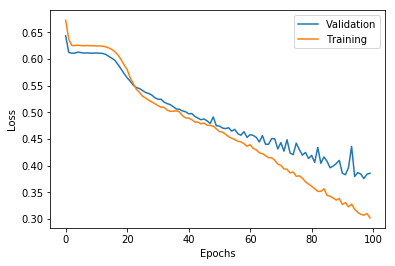

In [24]:
with open('./%s/hist_0.json' % path_info['model_info']['model_dir'], 'r') as f:
    history = json.load(f)
    
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['loss'], label='Training')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Test evauation and train evauation is the numpy array of the shape (number of fold, number of evaluation measures).

In [25]:
test_evaluation

array([[0.36566573, 0.82587063, 0.90647483, 0.64516127, 0.76473689,
        0.90136921],
       [0.59143341, 0.74626863, 0.9868421 , 0.        , 0.        ,
        0.50792158],
       [0.69738996, 0.68000001, 1.        , 0.        , 0.        ,
        0.44990808]])

In [26]:
train_evaluation

array([[0.31715596, 0.86374998, 0.95810562, 0.65737051, 0.7936185 ,
        0.93675572],
       [0.58998507, 0.70875001, 0.99121267, 0.01298701, 0.11345877,
        0.5970602 ],
       [0.58905673, 0.69125003, 1.        , 0.        , 0.        ,
        0.64586979]])

## 5. Load the pre-trained network for training

If you have a pre-trianed model, you warm_start next training using the pre-trained weights by setting the `warm_start` option in `training_info` to `True`. The file path of the pre-trained weights passed in the `warm_start_model` option. Below is the example:

In [27]:
warm_start_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.01',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'texa_selection_metrics': 'accuracy, sensitivity, specificity, gmeasure'
    },
    'training_info': {
        'warm_start':'True',
        'warm_start_model':'./example_result/weight.h5',
        'batch_size': '200',
        'epochs': '100'
    },
    'validation_info': {
        'batch_size': 'None', 
        'validation_size': '0.2'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [28]:
test_evaluation, train_evaluation, network = deepbiome.deepbiome_train(log, warm_start_network_info, path_info, 
                                                                       number_of_fold=3)

[root    |INFO|deepbiome.py:100] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:137] -------1 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:147] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:148] Build network for 1 simulation
[root    |INFO|build_network.py:505] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:506] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:510] Phylogenetic tree level list: ['Ge

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|deepbiome.py:157] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:158] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 0s 657us/step - loss: 0.3072 - binary_accuracy: 0.8797 - sensitivity: 0.9379 - specificity: 0.7269 - gmeasure: 0.8189 - auc: 0.9370 - val_loss: 0.3777 - val_binary_accuracy: 0.8313 - val_sensitivity: 0.9643 - val_specificity: 0.5208 - val_gmeasure: 0.7087 - val_auc: 0.8953
Epoch 2/100
640/640 [==============================] - 0s 65us/step - loss: 0.2973 - binary_accuracy: 0.8844 - sensitivity: 0.9597 - specificity: 0.7013 - gmeasure: 0.8171 - auc: 0.9383 - val_loss: 0.3685 - val_binary_accuracy: 0.8438 - val_sensitivity: 0.9554 - val_specificity: 0.5833 - val_gmeasure: 0.7465 - val_auc: 0.8977
Epoch 3/100
640/640 [==============================] - 0s 76us/step - loss: 0.2969 - binary_accuracy: 0.8891 - sensitivity: 0.9544 - specificity: 0.7345 - gmeasure: 0.8345 - auc: 0.9440 - val_loss: 0.3708 - val_binary_accuracy: 0.8438 - val_sensitivity: 0.9643 - val_specificity: 0.5625 - val_gmea

Epoch 26/100
640/640 [==============================] - 0s 75us/step - loss: 0.2656 - binary_accuracy: 0.8891 - sensitivity: 0.9581 - specificity: 0.7541 - gmeasure: 0.8496 - auc: 0.9579 - val_loss: 0.3627 - val_binary_accuracy: 0.8438 - val_sensitivity: 0.9643 - val_specificity: 0.5625 - val_gmeasure: 0.7365 - val_auc: 0.9051
Epoch 27/100
640/640 [==============================] - 0s 76us/step - loss: 0.2631 - binary_accuracy: 0.8922 - sensitivity: 0.9403 - specificity: 0.7636 - gmeasure: 0.8465 - auc: 0.9545 - val_loss: 0.3462 - val_binary_accuracy: 0.8438 - val_sensitivity: 0.9107 - val_specificity: 0.6875 - val_gmeasure: 0.7913 - val_auc: 0.9100
Epoch 28/100
640/640 [==============================] - 0s 72us/step - loss: 0.2675 - binary_accuracy: 0.8969 - sensitivity: 0.9145 - specificity: 0.8439 - gmeasure: 0.8776 - auc: 0.9574 - val_loss: 0.3468 - val_binary_accuracy: 0.8625 - val_sensitivity: 0.9554 - val_specificity: 0.6458 - val_gmeasure: 0.7855 - val_auc: 0.9107
Epoch 29/100


Epoch 51/100
640/640 [==============================] - 0s 70us/step - loss: 0.2412 - binary_accuracy: 0.9062 - sensitivity: 0.9472 - specificity: 0.7792 - gmeasure: 0.8583 - auc: 0.9613 - val_loss: 0.3415 - val_binary_accuracy: 0.8500 - val_sensitivity: 0.9643 - val_specificity: 0.5833 - val_gmeasure: 0.7500 - val_auc: 0.9196
Epoch 52/100
640/640 [==============================] - 0s 67us/step - loss: 0.2444 - binary_accuracy: 0.8891 - sensitivity: 0.9654 - specificity: 0.7593 - gmeasure: 0.8556 - auc: 0.9626 - val_loss: 0.3274 - val_binary_accuracy: 0.8687 - val_sensitivity: 0.9554 - val_specificity: 0.6667 - val_gmeasure: 0.7981 - val_auc: 0.9219
Epoch 53/100
640/640 [==============================] - 0s 66us/step - loss: 0.2389 - binary_accuracy: 0.9000 - sensitivity: 0.9393 - specificity: 0.8466 - gmeasure: 0.8897 - auc: 0.9670 - val_loss: 0.3176 - val_binary_accuracy: 0.8687 - val_sensitivity: 0.9375 - val_specificity: 0.7083 - val_gmeasure: 0.8149 - val_auc: 0.9241
Epoch 54/100


Epoch 76/100
640/640 [==============================] - 0s 79us/step - loss: 0.2181 - binary_accuracy: 0.9141 - sensitivity: 0.9572 - specificity: 0.8430 - gmeasure: 0.8979 - auc: 0.9753 - val_loss: 0.3103 - val_binary_accuracy: 0.8750 - val_sensitivity: 0.9464 - val_specificity: 0.7083 - val_gmeasure: 0.8188 - val_auc: 0.9302
Epoch 77/100
640/640 [==============================] - 0s 77us/step - loss: 0.2155 - binary_accuracy: 0.9125 - sensitivity: 0.9394 - specificity: 0.8305 - gmeasure: 0.8829 - auc: 0.9690 - val_loss: 0.3250 - val_binary_accuracy: 0.8687 - val_sensitivity: 0.9643 - val_specificity: 0.6458 - val_gmeasure: 0.7892 - val_auc: 0.9288
Epoch 78/100
640/640 [==============================] - 0s 73us/step - loss: 0.2198 - binary_accuracy: 0.9016 - sensitivity: 0.9619 - specificity: 0.7662 - gmeasure: 0.8579 - auc: 0.9743 - val_loss: 0.3116 - val_binary_accuracy: 0.8687 - val_sensitivity: 0.9464 - val_specificity: 0.6875 - val_gmeasure: 0.8066 - val_auc: 0.9301
Epoch 79/100


[root    |INFO|build_network.py:143] Training end with time 6.693759918212891!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_0.h5 
[root    |DEBUG|deepbiome.py:166] Save weight at ./example_result/weight_0.h5
[root    |DEBUG|deepbiome.py:169] Save history at ./example_result/hist_0.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.009623050689697266!
[root    |INFO|build_network.py:175] Evaluation: [0.22576484084129333, 0.90625, 0.9635701179504395, 0.7808765172958374, 0.8674268126487732, 0.9678009152412415]
[root    |INFO|build_network.py:169] Evaluation start!


201/201 [==============================] - 0s 24us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.012128114700317383!
[root    |INFO|build_network.py:175] Evaluation: [0.284936785697937, 0.8905472755432129, 0.935251772403717, 0.7903226017951965, 0.8597387075424194, 0.9432002902030945]
[root    |INFO|deepbiome.py:179] Compute time : 8.164530992507935
[root    |INFO|deepbiome.py:180] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:137] -------2 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:147] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:148] Build network for 2 simulation
[root    |INFO|build_network.py:5

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|deepbiome.py:157] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:158] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 1s 803us/step - loss: 0.5933 - binary_accuracy: 0.7016 - sensitivity: 0.9964 - specificity: 0.0087 - gmeasure: 0.0658 - auc: 0.6093 - val_loss: 0.5767 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4781
Epoch 2/100
640/640 [==============================] - 0s 72us/step - loss: 0.5920 - binary_accuracy: 0.7000 - sensitivity: 0.9930 - specificity: 0.0228 - gmeasure: 0.1249 - auc: 0.6177 - val_loss: 0.5953 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4804
Epoch 3/100
640/640 [==============================] - 0s 73us/step - loss: 0.5981 - binary_accuracy: 0.7063 - sensitivity: 0.9894 - specificity: 0.0504 - gmeasure: 0.2206 - auc: 0.6014 - val_loss: 0.5985 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0

640/640 [==============================] - 0s 68us/step - loss: 0.5875 - binary_accuracy: 0.7047 - sensitivity: 0.9927 - specificity: 0.0247 - gmeasure: 0.1333 - auc: 0.6818 - val_loss: 0.5813 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4744
Epoch 26/100
640/640 [==============================] - 0s 70us/step - loss: 0.5866 - binary_accuracy: 0.7000 - sensitivity: 0.9946 - specificity: 0.0083 - gmeasure: 0.0453 - auc: 0.6368 - val_loss: 0.5820 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4758
Epoch 27/100
640/640 [==============================] - 0s 73us/step - loss: 0.5869 - binary_accuracy: 0.7000 - sensitivity: 0.9948 - specificity: 0.0291 - gmeasure: 0.1110 - auc: 0.6309 - val_loss: 0.5806 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4746
Ep

640/640 [==============================] - 0s 74us/step - loss: 0.5832 - binary_accuracy: 0.7063 - sensitivity: 0.9944 - specificity: 0.0254 - gmeasure: 0.1339 - auc: 0.6452 - val_loss: 0.5798 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4840
Epoch 50/100
640/640 [==============================] - 0s 73us/step - loss: 0.5820 - binary_accuracy: 0.7109 - sensitivity: 0.9947 - specificity: 0.0565 - gmeasure: 0.2329 - auc: 0.6449 - val_loss: 0.5830 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4842
Epoch 51/100
640/640 [==============================] - 0s 72us/step - loss: 0.5808 - binary_accuracy: 0.7109 - sensitivity: 0.9929 - specificity: 0.0599 - gmeasure: 0.2404 - auc: 0.6499 - val_loss: 0.5843 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4846
Ep

640/640 [==============================] - 0s 74us/step - loss: 0.5748 - binary_accuracy: 0.7156 - sensitivity: 0.9856 - specificity: 0.1119 - gmeasure: 0.3234 - auc: 0.6656 - val_loss: 0.5888 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4919
Epoch 74/100
640/640 [==============================] - 0s 71us/step - loss: 0.5748 - binary_accuracy: 0.7156 - sensitivity: 0.9768 - specificity: 0.0907 - gmeasure: 0.2963 - auc: 0.6382 - val_loss: 0.5876 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4900
Epoch 75/100
640/640 [==============================] - 0s 73us/step - loss: 0.5743 - binary_accuracy: 0.7156 - sensitivity: 0.9641 - specificity: 0.1155 - gmeasure: 0.3254 - auc: 0.6465 - val_loss: 0.5855 - val_binary_accuracy: 0.7437 - val_sensitivity: 0.9917 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.4892
Ep

Epoch 98/100
640/640 [==============================] - 0s 61us/step - loss: 0.5715 - binary_accuracy: 0.7188 - sensitivity: 0.9616 - specificity: 0.1301 - gmeasure: 0.3483 - auc: 0.6480 - val_loss: 0.5999 - val_binary_accuracy: 0.7188 - val_sensitivity: 0.9417 - val_specificity: 0.0500 - val_gmeasure: 0.2170 - val_auc: 0.5017
Epoch 99/100
640/640 [==============================] - 0s 70us/step - loss: 0.5737 - binary_accuracy: 0.7219 - sensitivity: 0.9426 - specificity: 0.1677 - gmeasure: 0.3875 - auc: 0.6668 - val_loss: 0.5883 - val_binary_accuracy: 0.7312 - val_sensitivity: 0.9667 - val_specificity: 0.0250 - val_gmeasure: 0.1555 - val_auc: 0.5023
Epoch 100/100
640/640 [==============================] - 0s 65us/step - loss: 0.5692 - binary_accuracy: 0.7156 - sensitivity: 0.9721 - specificity: 0.0884 - gmeasure: 0.2488 - auc: 0.6498 - val_loss: 0.5809 - val_binary_accuracy: 0.7375 - val_sensitivity: 0.9833 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5025


[root    |INFO|build_network.py:143] Training end with time 6.830451726913452!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_1.h5 
[root    |DEBUG|deepbiome.py:166] Save weight at ./example_result/weight_1.h5
[root    |DEBUG|deepbiome.py:169] Save history at ./example_result/hist_1.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 6us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.012296915054321289!
[root    |INFO|build_network.py:175] Evaluation: [0.5730411410331726, 0.7250000238418579, 0.9912126660346985, 0.06926406919956207, 0.2620218098163605, 0.6369875073432922]
[root    |INFO|build_network.py:169] Evaluation start!


201/201 [==============================] - 0s 25us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.012672901153564453!
[root    |INFO|build_network.py:175] Evaluation: [0.5885742902755737, 0.746268630027771, 0.9802631735801697, 0.020408162847161293, 0.14144033193588257, 0.5285983085632324]
[root    |INFO|deepbiome.py:179] Compute time : 8.461602687835693
[root    |INFO|deepbiome.py:180] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:137] -------3 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:147] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:148] Build network for 3 simulation
[root    |INFO|build_network.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|deepbiome.py:157] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:158] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 0s 666us/step - loss: 0.5796 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6810 - val_loss: 0.6538 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5151
Epoch 2/100
640/640 [==============================] - 0s 74us/step - loss: 0.5829 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6697 - val_loss: 0.6543 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5147
Epoch 3/100
640/640 [==============================] - 0s 76us/step - loss: 0.5747 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6962 - val_loss: 0.6655 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0

Epoch 25/100
640/640 [==============================] - 0s 74us/step - loss: 0.5659 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6947 - val_loss: 0.6684 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5080
Epoch 26/100
640/640 [==============================] - 0s 71us/step - loss: 0.5664 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6805 - val_loss: 0.6675 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5080
Epoch 27/100
640/640 [==============================] - 0s 73us/step - loss: 0.5677 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.7193 - val_loss: 0.6682 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmea

Epoch 49/100
640/640 [==============================] - 0s 73us/step - loss: 0.5671 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6774 - val_loss: 0.6897 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5007
Epoch 50/100
640/640 [==============================] - 0s 73us/step - loss: 0.5623 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6953 - val_loss: 0.6803 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0200 - val_gmeasure: 0.1414 - val_auc: 0.5002
Epoch 51/100
640/640 [==============================] - 0s 79us/step - loss: 0.5661 - binary_accuracy: 0.6938 - sensitivity: 1.0000 - specificity: 0.0046 - gmeasure: 0.0340 - auc: 0.6935 - val_loss: 0.6825 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00

Epoch 73/100
640/640 [==============================] - 0s 73us/step - loss: 0.5607 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6882 - val_loss: 0.6943 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5055
Epoch 74/100
640/640 [==============================] - 0s 74us/step - loss: 0.5597 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6694 - val_loss: 0.6962 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5071
Epoch 75/100
640/640 [==============================] - 0s 75us/step - loss: 0.5603 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.7176 - val_loss: 0.6854 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmea

Epoch 97/100
640/640 [==============================] - 0s 76us/step - loss: 0.5590 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.7195 - val_loss: 0.6989 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5065
Epoch 98/100
640/640 [==============================] - 0s 71us/step - loss: 0.5551 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.6990 - val_loss: 0.6967 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00 - val_auc: 0.5071
Epoch 99/100
640/640 [==============================] - 0s 76us/step - loss: 0.5546 - binary_accuracy: 0.6922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - auc: 0.7526 - val_loss: 0.7004 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmea

[root    |INFO|build_network.py:143] Training end with time 6.6846489906311035!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_2.h5 
[root    |DEBUG|deepbiome.py:166] Save weight at ./example_result/weight_2.h5
[root    |DEBUG|deepbiome.py:169] Save history at ./example_result/hist_2.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008782625198364258!
[root    |INFO|build_network.py:175] Evaluation: [0.5850404500961304, 0.6912500262260437, 1.0, 0.0, 0.0, 0.6665226817131042]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 18us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.009485960006713867!
[root    |INFO|build_network.py:175] Evaluation: [0.7680084109306335, 0.6800000071525574, 1.0, 0.0, 0.0, 0.4273897111415863]
[root    |INFO|deepbiome.py:179] Compute time : 8.338343620300293
[root    |INFO|deepbiome.py:180] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:183] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:185] Train Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:188]       mean : [0.46128214 0.77416668 0.98492759 0.2833802  0.37648287 0.7571037 ]
[root    |INFO|deepbiome.py:189]        std : [0.16660791 0.09440787 0.01552226 0.35291767 0.36325686 0.14947256]
[root    |INFO|deepbiome.py:190] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:192] Test Evaluation : ['loss' 'binary_accuracy

Let's check the history plot again.

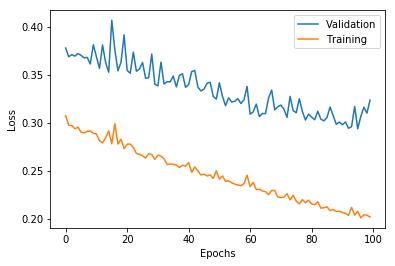

In [29]:
with open('./%s/hist_0.json' % path_info['model_info']['model_dir'], 'r') as f:
    history = json.load(f)
    
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['loss'], label='Training')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Load the pre-trained network for testing

To test the trained model, we can use the `deepbiome_test` function. If you use the index file, this function provides the evaluation using test index (index set not included in the index file) for each fold. If not, this function provides the evaluation using the whole samples. If `number_of_fold` is set to `k`, the function will test the model only with first `k` folds.

In [30]:
test_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.01',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'lr': '0.01',
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'texa_selection_metrics': 'accuracy, sensitivity, specificity, gmeasure',
        'network_class': 'DeepBiomeNetwork',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'normalizer': 'normalize_minmax',
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [31]:
test_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'evaluation': 'eval.npy',
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

In [32]:
evaluation = deepbiome.deepbiome_test(log, test_network_info, test_path_info, number_of_fold=3)

[root    |INFO|deepbiome.py:262] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:294] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:296] -------1 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:306] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:307] Build network for 1 fold testing
[root    |INFO|build_network.py:505] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:506] Read phylogenetic tree information from /DATA/home/muha/github_

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:316] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:317] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


201/201 [==============================] - 0s 347us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.20604419708251953!
[root    |INFO|build_network.py:175] Evaluation: [0.284936785697937, 0.8905472755432129, 0.935251772403717, 0.7903226017951965, 0.8597387075424194, 0.9432002902030945]
[root    |INFO|deepbiome.py:320] 
[root    |INFO|deepbiome.py:322] Compute time : 1.4026703834533691
[root    |INFO|deepbiome.py:323] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:296] -------2 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:306] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:307] Build network for 2 fold testin

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:316] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:317] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


201/201 [==============================] - 0s 392us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.22733139991760254!
[root    |INFO|build_network.py:175] Evaluation: [0.5885742902755737, 0.746268630027771, 0.9802631735801697, 0.020408162847161293, 0.14144033193588257, 0.5285983085632324]
[root    |INFO|deepbiome.py:320] 
[root    |INFO|deepbiome.py:322] Compute time : 1.4291009902954102
[root    |INFO|deepbiome.py:323] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:296] -------3 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:306] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:307] Build network for 3 fold te

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:316] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:317] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 454us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.22405052185058594!
[root    |INFO|build_network.py:175] Evaluation: [0.7680084109306335, 0.6800000071525574, 1.0, 0.0, 0.0, 0.4273897111415863]
[root    |INFO|deepbiome.py:320] 
[root    |INFO|deepbiome.py:322] Compute time : 1.4915955066680908
[root    |INFO|deepbiome.py:323] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:326] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:328] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:331]       mean : [0.54717316 0.77227197 0.97183832 0.27024359 0.33372635 0.63306277]
[root    |INFO|deepbiome.py:332]        std : [0.19937417 0.0879002  0.02709633 0.36784576 0.37640235 0.22315877]
[root    |INFO|deepbiome.py:333] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:336] Total Com

This function provide the evaluation result as a numpy array with a shape of (number of fold, number of evaluation measures).

In [33]:
print('      %s' % ''.join(['%16s'%'loss']+ ['%16s'%s.strip() for s in network_info['model_info']['metrics'].split(',')]))
print('Mean: %s' % ''.join(['%16.4f'%v for v in np.mean(evaluation, axis=0)]))
print('Std : %s' % ''.join(['%16.4f'%v for v in np.std(evaluation, axis=0)]))

                  loss binary_accuracy     sensitivity     specificity        gmeasure             auc
Mean:           0.5472          0.7723          0.9718          0.2702          0.3337          0.6331
Std :           0.1994          0.0879          0.0271          0.3678          0.3764          0.2232


## 7. Load the pre-trained network for prediction

If you want to predict using the pre-trained model, you can use the `deepbiome_prediction` function. If `number_of_fold` is setted as `k`, the function will predict only with first `k` folds sample's outputs.

In [34]:
prediction_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.01',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'texa_selection_metrics': 'accuracy, sensitivity, specificity, gmeasure'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [35]:
prediction_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'model_dir': './example_result/',
        'weight': 'weight_0.h5'
    }
}

In [36]:
prediction = deepbiome.deepbiome_prediction(log, prediction_network_info, prediction_path_info,
                                            num_classes = 1, number_of_fold=3)

[root    |INFO|deepbiome.py:393] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:420] -------1 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:429] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:430] Build network for 1 fold testing
[root    |INFO|build_network.py:505] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:506] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:510] Phylogenetic tree

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:440] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


1000/1000 [==============================] - 0s 45us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.048128604888916016!
[root    |INFO|deepbiome.py:444] Compute time : 0.9910094738006592
[root    |INFO|deepbiome.py:445] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:420] -------2 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:429] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:430] Build network for 2 fold testing
[root    |INFO|build_network.py:505] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:506] Read phylogenetic 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:440] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


1000/1000 [==============================] - 0s 36us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.03895401954650879!
[root    |INFO|deepbiome.py:444] Compute time : 0.9998486042022705
[root    |INFO|deepbiome.py:445] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:420] -------3 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:429] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:430] Build network for 3 fold testing
[root    |INFO|build_network.py:505] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:506] Read phylogenetic t

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:440] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


1000/1000 [==============================] - 0s 45us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.04842853546142578!
[root    |INFO|deepbiome.py:444] Compute time : 1.0276074409484863
[root    |INFO|deepbiome.py:445] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:449] Total Computing Ended
[root    |INFO|deepbiome.py:450] -----------------------------------------------------------------


In [37]:
prediction.shape

(3, 1000, 1)

In [38]:
prediction[0,:10]

array([[0.82867134],
       [0.9641832 ],
       [0.10825878],
       [0.08233523],
       [0.9999995 ],
       [0.9699232 ],
       [0.24979487],
       [0.08233523],
       [0.92984045],
       [0.9995712 ]], dtype=float32)